In [1]:
#Libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import pandas as pd
import os

# Resistance Calculations From Lyo Cycle Data

### Inputs, Data Loading

In [3]:
#Input Parameters
SAin = float(input("Enter Surface Area In(cm^2): ")) #5.982843996
print(SAin)
SAout = float(input("Enter Surface Area Out(cm^2): ")) #7.0685775
print(SAout)
ice_dens = float(input("Enter Ice Density: ")) #0.918
print(ice_dens)
dens = float(input("Enter Density: ")) #1.036
print(dens)
fill_vol = float(input("Enter Fill Volume(ml): ")) #6.3
print(fill_vol)
water_cont = float(input("Enter Water Content: ")) #0.484
print(water_cont)
dry_cake=(fill_vol*dens)/(SAin*ice_dens)
print("Dry Cake Initial Height:",dry_cake)
lam=0.00358

Enter Surface Area In(cm^2): 5.982843996
5.982843996
Enter Surface Area Out(cm^2): 7.0685775
7.0685775
Enter Ice Density: 0.918
0.918
Enter Density: 1.036
1.036
Enter Fill Volume(ml): 6.3
6.3
Enter Water Content: 0.484
0.484
Dry Cake Initial Height: 1.1883652534350033


In [4]:
#Initial Data(SV File)
file_location = r'C:\Users\sbadih\OneDrive - Gilead Sciences\Trodelvy 2.0 Modelling Data\GS-0132_F2_LL_SV_mins.xlsx'
assert os.path.isfile(file_location)
df = pd.read_excel(file_location,sheet_name='GS-0132_F2_LL_SV_mins')
print(list(df.columns))

#Elapsed Time Array
time=(df[['Timestamp']]).values #every 5 mins
t_m=np.arange(0,len(time)*5,5) #Create array for time passed in increments of 5 mins


#Pirani Pressure
pirani_pres=(df[[' SPLYO.CHAMBER_PIRANI.F_CV']]).values

#Chamber Pressure
cham_pres=(df[[' SPLYO.CHAMBER_CM.F_CV']]).values

['Timestamp', ' SPLYO.CONDENSER_TEMPERATURE.F_CV', ' SPLYO.SHELF_OUTLET.F_CV', ' SPLYO.SHELF_INLET.F_CV', ' SPLYO.SHELF_SP.F_CV', ' SPLYO.TC_AVG.F_CV', ' SPLYO.VACUUM_SP.F_CV', ' SPLYO.CHAMBER_CM.F_CV', ' SPLYO.ROUGH_VACUUM.F_CV', ' SPLYO.CHAMBER_PIRANI.F_CV', ' SPLYO.CONDENSER_VACUUM.F_CV']


In [5]:
#Initial Data(PP File)
file_location1 = r'C:\Users\sbadih\OneDrive - Gilead Sciences\Trodelvy 2.0 Modelling Data\GS-0132_F2_LL_PP_mins.xlsx'
assert os.path.isfile(file_location1)
df1 = pd.read_excel(file_location1,sheet_name='GS-0132_F2_LL_PP_mins')
print("Headers:")
print(list(df1.columns))

Headers:
['Timestamp', ' SPLYO.TC01.F_CV', ' SPLYO.TC02.F_CV', ' SPLYO.TC03.F_CV', ' SPLYO.TC04.F_CV', ' SPLYO.TC05.F_CV', ' SPLYO.TC06.F_CV', ' SPLYO.TC07.F_CV', ' SPLYO.TC08.F_CV', ' SPLYO.TC09.F_CV', ' SPLYO.TC10.F_CV', ' SPLYO.TC11.F_CV', ' SPLYO.TC12.F_CV', ' SPLYO.TC13.F_CV', ' SPLYO.TC14.F_CV', ' SPLYO.TC15.F_CV', ' SPLYO.TC16.F_CV', ' SPLYO.TC_AVG.F_CV']


### Modify This Section to Choose Which Thermocouple to Look At

In [6]:
#Extract Thermcouple Reading Temperatures
Tc=(df1[[' SPLYO.TC06.F_CV']]).values #Thermocouple Reading
Tp=(df[[' SPLYO.SHELF_OUTLET.F_CV']]).values #Shelf Temperature Reading

### Sublimation Pressure

In [7]:
#Function to Calc. Sublimation Pressure
def sub_p(T): #input is temperature
    sp=(np.exp(24.01849-6144.96/((T)+273)))*1000
    return sp

In [8]:
#Store Sublimation Pressures
sub_pres=sub_p(Tc)
print("Sublimation Pressure Shape:",sub_pres.shape)

Sublimation Pressure Shape: (1440, 1)


##### Index Setup

In [11]:
#Need to automatically find the index at which we stop calculating any values
    #This is determined by when the Chamber CM reading becomes close to the pirani reading indicating end of primary drying
    
#Start Index
    #This will vary depending on the vial configuration
    #Start index is where the calculated sublimation pressure is equal to the Chamber CM reading(ie where sublimation starts(primary drying))
# 2NN
tol1= float(input("Enter Start Index Criteria for Sublimation Pressure: ")) #98.5
print(tol1)
tol2=float(input("Enter Stop Index Criteria for Pirani Convergence: ")) #100
print(tol2)
minimum=[]
ind=[]
for i in range(len(cham_pres)):
    if sub_pres[i]<tol1:
        ind.append(i)
        minimum.append(cham_pres[i]-sub_pres[i])
minimum=np.array(minimum) #convert list to array
min_ind=np.argmin(minimum) #Find the index in the minimum array where the minimum difference occurs
strt_ind=ind[min_ind] #Find the index in the sublimation pressure where the minimum occurs

print("Start Index:",strt_ind)

#Stop Index
index=[]
diff=[]
for i in range(len(pirani_pres[strt_ind2:])): #start where the primary drying starts
    if cham_pres[i+strt_ind2]<tol2:
        index.append(i+strt_ind2)
        diff.append(pirani_pres[i+strt_ind2]-cham_pres[i+strt_ind2])
diff=np.array(diff)
min_diff=np.argmin(diff) #find index where minimum occurs
   #Stop Index is the same for all vial configurations 
stop_ind=index[min_diff]
print("Stop Index is:",stop_ind) 

Enter Start Index Criteria for Sublimation Pressure: 98.5
98.5
Enter Stop Index Criteria for Pirani Convergence: 100
100.0
Start Index: 230
Stop Index is: 976


Note: The indices here are the points we will set to zero and all values after that is where the calculations start.This applies to Kv calculations up to the resistance calculations on the spreadsheet. 

In [13]:
#Modify Sub. Pressures based on start indices indicating beginning of sublimation where sub. pres=chamber pres and end indices where pirani converges to chamber pressure
sub_pres_new=sub_pres[strt_ind:stop_ind] 
print("New Array Shape for Sub. Pressures:\n")
print(sub_pres_new.shape)

New Array Shape for Sub. Pressures:

(746, 1)


### Kv Values(Vial Heat Transfer Coefficient)

In [52]:
#Kv Parameters
a_kv=0.000817654
b_kv=0.00045
c_kv=1.320652597

In [53]:
#Kv Value Calculations
def Kv_calc(p,factor): #Inputs are pirani pressure reading and adjustment factor
    return a_kv+(b_kv*(p/1000))/ (1+(c_kv*(p/1000))) *factor #might need to adjust the rounding

In [16]:
# Kv Calculations Using the Hyperplane Fitting
value = float(input("Enter your Kv value: ")) #0.00020961432864185497
print(value)
kv=np.repeat(value,len(pirani_pres[strt_ind:stop_ind]))
print("Kv Shape:",kv.shape)

Enter your Kv value: 0.00020961432864185497
0.00020961432864185497
Kv Shape: (746,)


### Heat Flow

In [17]:
#Heat Flow Calculations
def heat_flow(T,K,index): #inputs are temperature and vial heat transfer coefficient
    hf=np.zeros((K.size))
    for i in range(len(K)):
        hf[i]=abs(Tp[i+index]-T[i+index])*K[i] #Make sure we are sampling the time points correctly
    return hf

In [18]:
#HF calc. values
hf_old=heat_flow(Tc,kv,strt_ind)
#Store indices where hf is zero for later use
ind2_zero=[]
for i in range(len(hf_old)):
    if hf_old[i]==0:
        ind2_zero.append(i)
# #Remove all zero values to prevent infinite resistance calculations
hf=np.array([i for i in hf_old if i != 0])

print("Size:",hf.shape)
#Now no need to use the start/stop indices because everything will depend on previous steps that we already truncated

Size: (746,)


In [19]:
#Setting Zero Initial Condition
hf[0]=0    

### Sublimation Rate

In [20]:
#Sub. Rate Calc.
def sub_rate(HF,S): #inputs are heat flow and outer surface area
    sr=HF*(S/676)
    return sr

In [21]:
#Sublimation Rate Calc. Values
sr=sub_rate(hf,SAout)
print("Sublimation Rate Shape:",sr.shape)

Sublimation Rate Shape: (746,)


In [22]:
print(sr)

[0.00000000e+00 6.29054381e-05 6.46588998e-05 6.31246208e-05
 6.18095245e-05 6.09327937e-05 5.98368801e-05 5.89601493e-05
 5.80834184e-05 5.72066876e-05 5.65491395e-05 5.58915913e-05
 5.52340432e-05 5.45764951e-05 5.41381296e-05 5.36997642e-05
 5.30422161e-05 5.26038507e-05 5.21654852e-05 5.17271198e-05
 5.12887544e-05 5.10695717e-05 5.06312063e-05 5.01928408e-05
 4.99736581e-05 4.97544754e-05 4.95352927e-05 4.90969273e-05
 4.88777446e-05 4.86585619e-05 4.84393792e-05 4.82201964e-05
 4.80010137e-05 4.77818310e-05 4.75626483e-05 4.73434656e-05
 4.71242829e-05 4.69051002e-05 4.69051002e-05 4.66859175e-05
 4.64667348e-05 4.62475520e-05 4.60283693e-05 4.60283693e-05
 4.58091866e-05 4.58091866e-05 4.55900039e-05 4.53708212e-05
 4.53708212e-05 4.51516385e-05 4.51516385e-05 4.49324558e-05
 4.47132731e-05 4.47132731e-05 4.47132731e-05 4.44940904e-05
 4.44940904e-05 4.42749076e-05 4.42749076e-05 4.40557249e-05
 4.40557249e-05 4.38365422e-05 4.38365422e-05 4.38365422e-05
 4.36173595e-05 4.361735

### Mass Sublimed

In [23]:
#Mass Sublimed Function
    #The index is the spreadsheet row-2
def mass_sub(SR,t,index): #inputs are sublimation rate. time elapsed and start index(indicating beginning of sublimation)
    ms=np.zeros(SR.shape) #initialize array to store mass sublimed 
    for i in range(SR.shape[0]):
        if i==0:
            ms[i]=0
        else:
            ms[i]=ms[i-1]+((SR[i-1]+SR[i])/2)*(t_m[i+index]-t_m[i-1+index])*60 #Making sure to match the time indices
    return ms

In [26]:
#Mass Sublimed Calc. Values
ms=mass_sub(sr,t_m,strt_ind)
print("Size:",ms.shape)
print(ms)

Size: (746,)
[0.         0.00943582 0.02857047 0.04773799 0.06647812 0.08488946
 0.10300492 0.12082447 0.138381   0.15567452 0.17273789 0.189604
 0.20627285 0.22274443 0.23905162 0.25522731 0.27123861 0.28708552
 0.30280092 0.31838481 0.33383719 0.34919094 0.36444605 0.37956966
 0.39459463 0.40955385 0.42444732 0.43924215 0.45393835 0.4685688
 0.48313349 0.49763243 0.51206561 0.52643304 0.54073471 0.55497062
 0.56914079 0.58324519 0.59731672 0.61135538 0.62532827 0.63923542
 0.65307681 0.66688532 0.68066095 0.69440371 0.70811358 0.72175771
 0.73536895 0.74894732 0.76249282 0.77600543 0.78945229 0.80286627
 0.81628025 0.82966136 0.84300958 0.85632493 0.86960741 0.882857
 0.89607372 0.90925756 0.92240852 0.93555948 0.94867757 0.96176278
 0.97484799 0.98790032 1.00091977 1.01393922 1.02695867 1.03994525
 1.05289895 1.06585265 1.07880634 1.09172717 1.10461511 1.11750305
 1.130391   1.14324606 1.15606825 1.16889044 1.18171263 1.19450194
 1.20725837 1.22001481 1.23277124 1.24552767 1.2582841

### Dry Layer Height

In [27]:
#Dry Layer Height Function
def dry_h(MS): #Input is mass sublimated
    dlh=MS/(ice_dens*water_cont*SAin) #Since we set ms[0]=0, no need to reset initial conditions here
    return dlh

In [28]:
#Dry Layer Height Calculated
dlh=dry_h(ms)
print("Size:",dlh.shape)
print("Final Dry Layer Height Predicted By Model:",dlh[dlh.shape[0]-1])

Size: (746,)
Final Dry Layer Height Predicted By Model: 1.8894943439672567


Note: Model predicts the dry layer height well as this value is close to what was measured experimentally as the dry layer height.

### Sublimation Temperature

In [29]:
# Sublimation Temperature Function
def sub_temp(T,HF,DLH,strt_index,index,stop_index): #inputs are temperature,heat flow,dry layer height,start index and the zeros HF index
    f=((HF*(dry_cake-DLH))/lam)
    T=T[strt_index:stop_index]
    T=np.delete(T, index)
    T=T.reshape(f.size) #Get rid of the extra second dimension
    st=T-f
    return st

In [30]:
# Sublimation Temperature Calculations
st=sub_temp(Tc,hf,dlh,strt_ind,ind2_zero,stop_ind)
print("Size:",st.shape) #Again shapes should match

Size: (746,)


In [31]:
#Set Initial Condtions
st[0]=0   

### Measured Resistance(Experimental)

In [32]:
#Measured Resistance Function
def res_calc(SP,CM,SR,strt_ind,index,stop_index): #Inputs are sublimation pressure, chamber pressure,sublimation rate and start index
    SP=SP.reshape(SP.shape[0]) #Get rid of extra dimension
    CM=CM.reshape(CM.shape[0])
    SP=SP[strt_ind:stop_index]
    CM=CM[strt_ind:stop_index] #Make sure we're extracting the correct pressures
    SP=np.delete(SP, index)
    CM=np.delete(CM, index)
    r_m=(SP-CM)*(SAin/(SR*3600))
    r_m[0]=0 #Set initial condition
    return r_m

In [33]:
#Measured Resistance Calculations
rm=res_calc(sub_pres,cham_pres,sr,strt_ind,ind2_zero,stop_ind)
print("Size:",rm.shape)

Size: (746,)


<ipython-input-32-4b3398be3b6b>:9: RuntimeWarning: divide by zero encountered in true_divide
  r_m=(SP-CM)*(SAin/(SR*3600))


Text(0, 0.5, 'Resistance[(mT*hr*cm2/g)]')

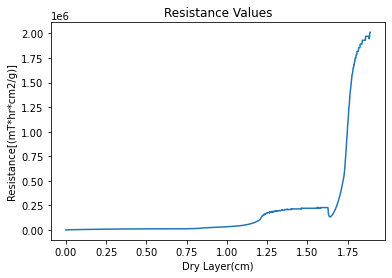

In [34]:
#Visualize Measured Resistance Values
plt.plot(dlh,rm)
plt.title("Resistance Values")
plt.xlabel("Dry Layer(cm)")
plt.ylabel("Resistance[(mT*hr*cm2/g)]")

Text(0.5, 1.0, 'Resistance Values For 4 Vial Cases')

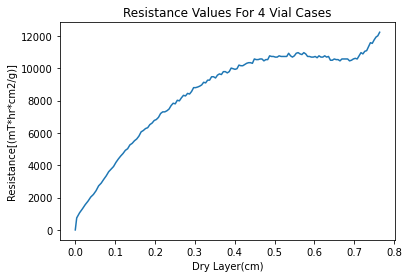

In [35]:
plt.plot(dlh[0:150],rm[0:150])
plt.xlabel("Dry Layer(cm)")
plt.ylabel("Resistance[(mT*hr*cm2/g)]")
plt.title("Resistance Values For 4 Vial Cases")

### OLS for Resistance 

In [73]:
R_calc=np.array([rm_2,rm_3,rm_4,rm_core],dtype="object")
d=np.array([dlh_2,dlh_3,dlh_4,dlh_core],dtype="object")
print(R_calc[1].shape)
print(len(R_calc))
ic2=np.array([0,52500,2])
ic3=np.array([0,93000,3.5])
ic4=np.array([0,120100,5.9])
ic_c=np.array([0,120100,5.9])
ic=np.array([ic2,ic3,ic4,ic_c])
print(ic)

(745,)
4
[[0.000e+00 5.250e+04 2.000e+00]
 [0.000e+00 9.300e+04 3.500e+00]
 [0.000e+00 1.201e+05 5.900e+00]
 [0.000e+00 1.201e+05 5.900e+00]]


In [74]:
print("Time I fitted to(hrs):",t_m[150]/60)

Time I fitted to(hrs): 12.5


Parameters: [1.16346289e+01 1.50000096e+05 1.21896835e+01]


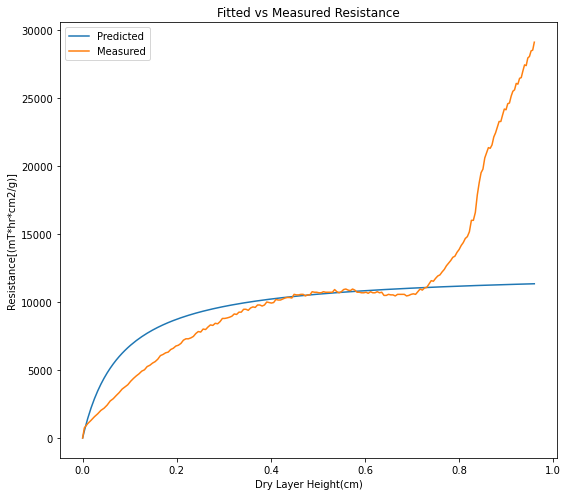

In [40]:
#Least Squares Fitting of Resistance Values

#Define matrices to hold Calculated Resistance Values,Dry Layer Height(measured), and initial condition estimates
R_calc_all=np.array([rm],dtype="object")
d_all=np.array([dlh],dtype="object")
ic=np.array([0,150000,4])
ic=np.array([ic])
x=np.array([200]) #ending up fitting up to the 125th time step ()
plt.figure(figsize=(8, 7))
for i in range(len(R_calc_all)): #loop over vial cases
    R_calc=(R_calc_all[i][0:x[i]]).astype("float") #Select appropriate R and d values for this run, and truncate 
    d=(d_all[i][0:x[i]]).astype("float")
    #Define Residuals Function
    def residuals(theta,d,R_calc):
        R_fit = theta[0]+((theta[1]*d)/(1+theta[2]*d)) #Calculated Resistance
        res=R_fit-R_calc      
        return res

    #Define Parameter Set
        #theta=[a,b,c]
    theta_0=(ic[i]).astype("float") #Set initial Condition

    #Least Squares Fitting
    param=least_squares(residuals,theta_0, loss='soft_l1', f_scale=0.1,args=(d,R_calc))
    print("Parameters:",param.x)
    
    #Find predicted resistance values
    R_pred=param.x[0]+((param.x[1]*d)/(1+param.x[2]*d)) 

    #Plotting
    labels_p=["Predicted"]
    labels_m=["Measured"]
    plt.plot(d,R_pred,label=labels_p[i])
    plt.plot(d,R_calc,label=labels_m[i])
    plt.xlabel("Dry Layer Height(cm)")
    plt.ylabel("Resistance[(mT*hr*cm2/g)]")
    plt.title("Fitted vs Measured Resistance")
    plt.legend()
    plt.tight_layout()

In [76]:
#Done